In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/데이터스쿨/실습파일/ML_project/dataset.csv', index_col=0)
exited = {'Existing Customer': 0, 'Attrited Customer':1}
gender = {'M':0, 'F':1}
education = {'Uneducated': 0, 'High School':1, 'College':2, 'Graduate':3, 'Post-Graduate': 4, 'Doctorate':5, 'Unknown':6}
marital = {'Single':0, 'Married': 1, 'Divorced':2, 'Unknown':3}
income = {'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +':4, 'Unknown':5}
card = {'Blue':0, 'Silver':1 , 'Gold': 2, 'Platinum': 3}
df['Exited'] = df['Exited'].map(exited)
df['Gender'] = df['Gender'].map(gender)
df['Education'] = df['Education'].map(education)
df['Marital'] = df['Marital'].map(marital)
df['Income'] = df['Income'].map(income)
df['Card_type'] = df['Card_type'].map(card)
df.head()

,Exited,Age,Gender,Dependents,Education,Marital,Income,Card_type,Tenure,Product_Cnt,Inactive_Months,Contacts_Cnt,Credit_Limit,Revolv_Bal,Avg_OTB,Avg_Util_Ratio,Trans_Amt,Trans_Cnt,Amt_Chng_Q4_Q1,Cnt_Chng_Q4_Q1
0,0,45,0,3,1,1,2,0,39,5,1,3,12691.0,777,11914.0,0.061,1144,42,1.335,1.625
1,0,49,1,5,3,0,0,0,44,6,1,2,8256.0,864,7392.0,0.105,1291,33,1.541,3.714
2,0,51,0,3,3,1,3,0,36,4,1,0,3418.0,0,3418.0,0.000,1887,20,2.594,2.333
3,0,40,1,4,1,3,0,0,34,3,4,1,3313.0,2517,796.0,0.760,1171,20,1.405,2.333
4,0,40,0,3,0,1,2,0,21,5,1,0,4716.0,0,4716.0,0.000,816,28,2.175,2.500


---

### split 후 오버샘플링

In [ ]:
X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

# 오버샘플링
b_smote = BorderlineSMOTE(random_state=13)
X_resampled, y_resampled = b_smote.fit_resample(X_train, y_train)

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=0,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.7
)
estimators = [('scaler', StandardScaler()), ('clf', model)]

pipe = Pipeline(estimators)

In [ ]:
pipe.fit(X_resampled, y_resampled)
pred = pipe.predict(X_test)
print('accuracy: ', accuracy_score(y_test, pred))
print('precision: ', precision_score(y_test, pred))
print('recall: ', recall_score(y_test, pred))
print('f1: ', f1_score(y_test, pred))
print('auc: ', roc_auc_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

accuracy:  0.9521224086870681
precision:  0.8
recall:  0.9353846153846154
f1:  0.8624113475177304
auc:  0.9453525075747298
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1701
           1       0.80      0.94      0.86       325

    accuracy                           0.95      2026
   macro avg       0.89      0.95      0.92      2026
weighted avg       0.96      0.95      0.95      2026

[[1625   76]
 [  21  304]]


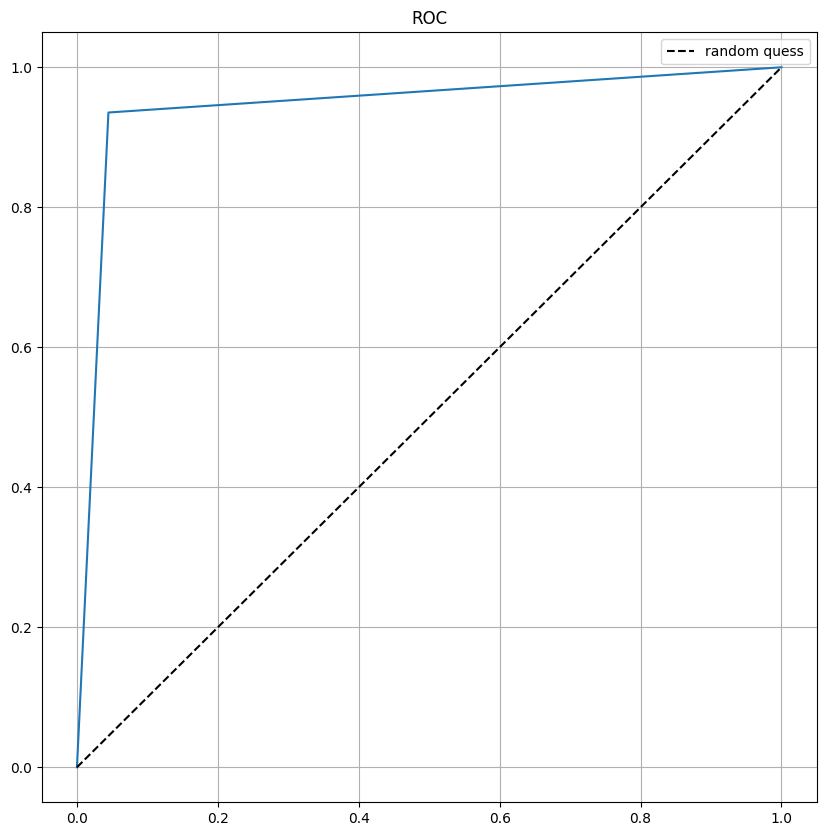

In [ ]:
plt.figure(figsize=(10, 10))

ypred = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label='random quess')
plt.title('ROC')
plt.legend()
plt.grid()
plt.show()